# Лабораторная 5

In [3]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 1.1 MB/s eta 0:00:09
   --- ------------------------------------ 0.8/9.6 MB 1.2 MB/s eta 0:00:08
   ----- ---------------------------------- 1.3/9.6 MB 1.4 MB/s eta 0:00:07
   ------ --------------------------------- 1.6/9.6 MB 1.4 MB/s eta 0:00:06
   -------- ------------------------------- 2.1/9.6 MB 1.5 MB/s eta 0:00:05
   --------- ------------------------------ 2.4/9.6 MB 1.5 MB/s eta 0:00:05
   ------------ --------------------------- 2.9/9.6 MB 1.6 MB/s eta 0:00:05
   --------------- ------------------------ 3.7/9.6 MB 1.8 MB/s eta 0:00:04
   ----------------- ---------------------- 4.2/9.6 MB 1.9 MB/s eta 0:00:03
   -------------------- ------------------- 5.0/9.6 MB 2.0 MB/s eta 0:00:03
   ------------------------ -----

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error


Загрузка и подготовка данных

In [8]:
df = pd.read_csv("lab5.csv")

df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df = df.sort_values(df.columns[0]).set_index(df.columns[0])

y = df.iloc[:, 0].astype(float)
y.name = "employment_thousands"


c:\Users\User-1\.conda\envs\cuda\lib\site-packages\pandas\core\indexes\base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


Визуализация временного ряда

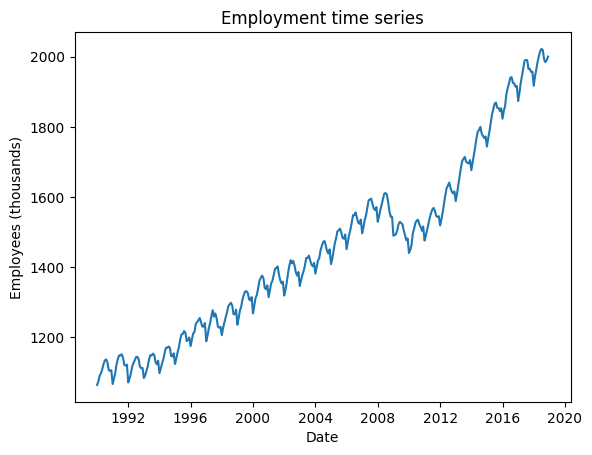

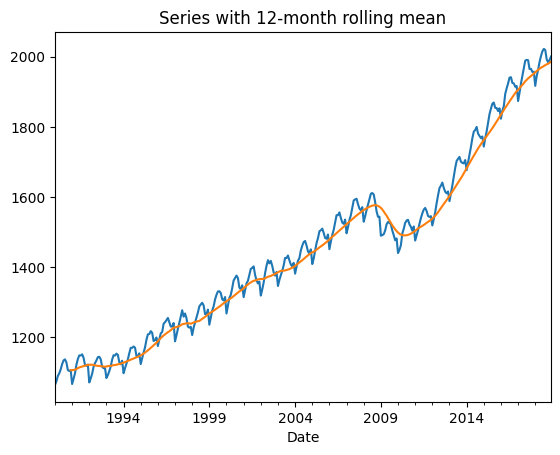

In [9]:
plt.figure()
plt.plot(y)
plt.title("Employment time series")
plt.xlabel("Date")
plt.ylabel("Employees (thousands)")
plt.show()

plt.figure()
y.plot()
y.rolling(12).mean().plot()
plt.title("Series with 12-month rolling mean")
plt.show()


Декомпозиция (тренд, сезонность, остатки)

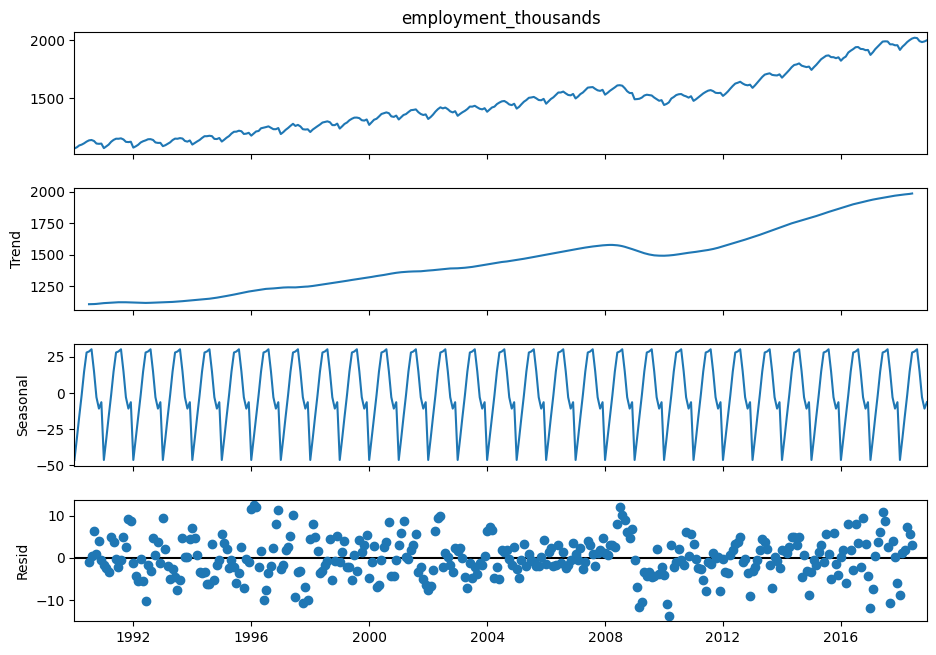

Series([], Name: resid, dtype: float64)

In [10]:
decomp = seasonal_decompose(y, model="additive", period=12)

fig = decomp.plot()
fig.set_size_inches(10, 7)
plt.show()

resid = decomp.resid.dropna()
z = (resid - resid.mean()) / resid.std(ddof=0)
anomalies = z[np.abs(z) >= 3]

anomalies


Проверка стационарности

In [11]:
def adf_test(series):
    return adfuller(series.dropna())[1]

def kpss_test(series):
    return kpss(series.dropna(), regression="c", nlags="auto")[1]

adf_p_raw = adf_test(y)
kpss_p_raw = kpss_test(y)

adf_p_raw, kpss_p_raw


C:\Users\User-1\AppData\Local\Temp\ipykernel_8180\1998934432.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(series.dropna(), regression="c", nlags="auto")[1]


(np.float64(0.9931070655289933), np.float64(0.01))

Вывод:
Ряд нестационарный.

Преобразование ряда

In [12]:
y_log = np.log(y)
y_log_diff = y_log.diff(12).dropna()

adf_p_diff = adf_test(y_log_diff)
kpss_p_diff = kpss_test(y_log_diff)

adf_p_diff, kpss_p_diff


C:\Users\User-1\AppData\Local\Temp\ipykernel_8180\1998934432.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(series.dropna(), regression="c", nlags="auto")[1]


(np.float64(0.04181858388988027), np.float64(0.1))

Ряд стационарный.

Train / Test

In [13]:
test_size = 12

y_train = y[:-test_size]
y_test = y[-test_size:]

y_train_log = np.log(y_train)


Обучение SARIMA

In [14]:
model = SARIMAX(
    y_train_log,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit(disp=False)


c:\Users\User-1\.conda\envs\cuda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User-1\.conda\envs\cuda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User-1\.conda\envs\cuda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Прогноз и метрики

In [15]:
forecast_log = res.get_forecast(steps=test_size)
forecast = np.exp(forecast_log.predicted_mean)

mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))

mae, rmse


(19.54601075157454, np.float64(23.15476328769687))

Визуализация прогноза

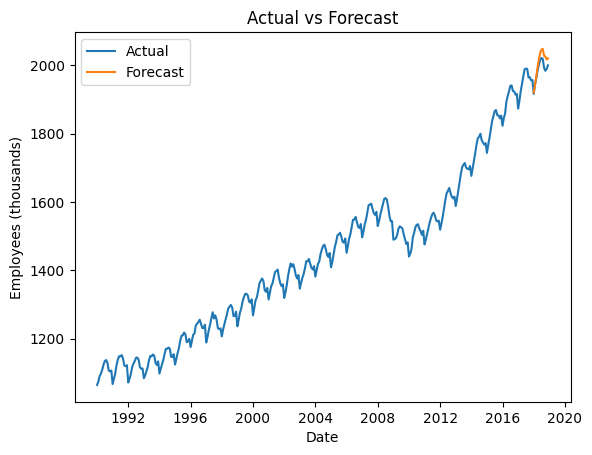

In [16]:
plt.figure()
plt.plot(y, label="Actual")
plt.plot(forecast.index, forecast, label="Forecast")
plt.title("Actual vs Forecast")
plt.xlabel("Date")
plt.ylabel("Employees (thousands)")
plt.legend()
plt.show()


Прогноз на будущее

c:\Users\User-1\.conda\envs\cuda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User-1\.conda\envs\cuda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User-1\.conda\envs\cuda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


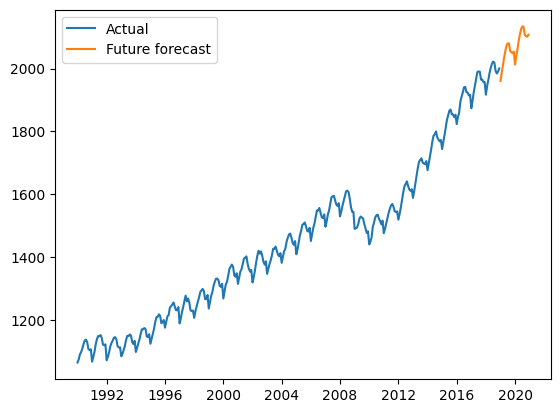

In [17]:
future_steps = 24

model_full = SARIMAX(
    np.log(y),
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

future_log = model_full.get_forecast(steps=future_steps)
future_forecast = np.exp(future_log.predicted_mean)

plt.figure()
plt.plot(y, label="Actual")
plt.plot(future_forecast.index, future_forecast, label="Future forecast")
plt.legend()
plt.show()


Полученный прогноз демонстрирует сохранение выявленного восходящего тренда и годовой сезонности. Модель SARIMA корректно воспроизводит структуру временного ряда, включая регулярные сезонные колебания, и обеспечивает плавное продолжение динамики занятости в прогнозируемый период.